In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from pytorchtools import EarlyStopping #from https://github.com/Bjarten/early-stopping-pytorch
from models import * #from https://github.com/kuangliu/pytorch-cifar

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [3]:
#set random seed
random_seed = 3
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [4]:
nepoch = 10000
early_stop = True
Patience = 15

In [5]:
# transform_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2,pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2,pin_memory = True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
#using codebase from https://github.com/kuangliu/pytorch-cifar

# Model

print('==> Building model..')

# net = VGG('VGG19')
# net = PreActResNet18()
# net = GoogLeNet()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF() 
# net = SimpleDLA()
# net = DenseNet121()

net = ResNet18()  


# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     net = nn.DataParallel(net)

net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4,betas=(0.99, 0.9999))

==> Building model..


In [7]:
from datetime import datetime

train_loss = []
test_loss = []
train_acc = []
test_acc = []

early_stopping = EarlyStopping(patience= Patience, verbose=True)

for epoch in range(nepoch): 
    
    start = datetime.now()
    
    print(f"Epoch {epoch}")
    
    #training
    net.train()  

    train_loss_total = 0
    correct_train = 0
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_total += outputs.shape[0] * loss.item()
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct_train += pred.eq(labels.view_as(pred)).sum().item()
    train_loss_epoch = train_loss_total / len(trainloader.dataset)
    train_acc_epoch = 100. * correct_train / len(trainloader.dataset)
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss_epoch, correct_train, len(trainloader.dataset),train_acc_epoch
        ))
    
    #testing
    net.eval()
    
    test_loss_total = 0
    correct_test = 0
    
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.to(device), labels.to(device)
            outputs = net(data)
            loss_test = criterion(outputs, labels)
            test_loss_total += outputs.shape[0] * loss_test.item()
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_test += pred.eq(labels.view_as(pred)).sum().item()

    test_loss_epoch = test_loss_total/ len(testloader.dataset)
    test_acc_epoch = 100. * correct_test / len(testloader.dataset)
    test_loss.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss_epoch, correct_test, len(testloader.dataset),
        test_acc_epoch))
    
    elapsed_time =  datetime.now() - start
    print(f"{elapsed_time.total_seconds()} seconds")
    
    if early_stop:
        early_stopping(test_loss_epoch, net)

        if early_stopping.early_stop:
            print("Early stopping")
            break


if early_stop:
    net.load_state_dict(torch.load('checkpoint.pt'))

Epoch 0
Train set: Average loss: 1.4997, Accuracy: 22412/50000 (45%)
Test set: Average loss: 1.2174, Accuracy: 5571/10000 (56%)
9.969247 seconds
Validation loss decreased (inf --> 1.217397).  Saving model ...
Epoch 1
Train set: Average loss: 1.0935, Accuracy: 30428/50000 (61%)
Test set: Average loss: 0.9687, Accuracy: 6570/10000 (66%)
9.681528 seconds
Validation loss decreased (1.217397 --> 0.968668).  Saving model ...
Epoch 2
Train set: Average loss: 0.8736, Accuracy: 34362/50000 (69%)
Test set: Average loss: 0.8048, Accuracy: 7186/10000 (72%)
9.918527 seconds
Validation loss decreased (0.968668 --> 0.804824).  Saving model ...
Epoch 3
Train set: Average loss: 0.7390, Accuracy: 36909/50000 (74%)
Test set: Average loss: 0.7321, Accuracy: 7385/10000 (74%)
9.766997 seconds
Validation loss decreased (0.804824 --> 0.732146).  Saving model ...
Epoch 4
Train set: Average loss: 0.6287, Accuracy: 38899/50000 (78%)
Test set: Average loss: 0.6635, Accuracy: 7712/10000 (77%)
9.505904 seconds
Vali

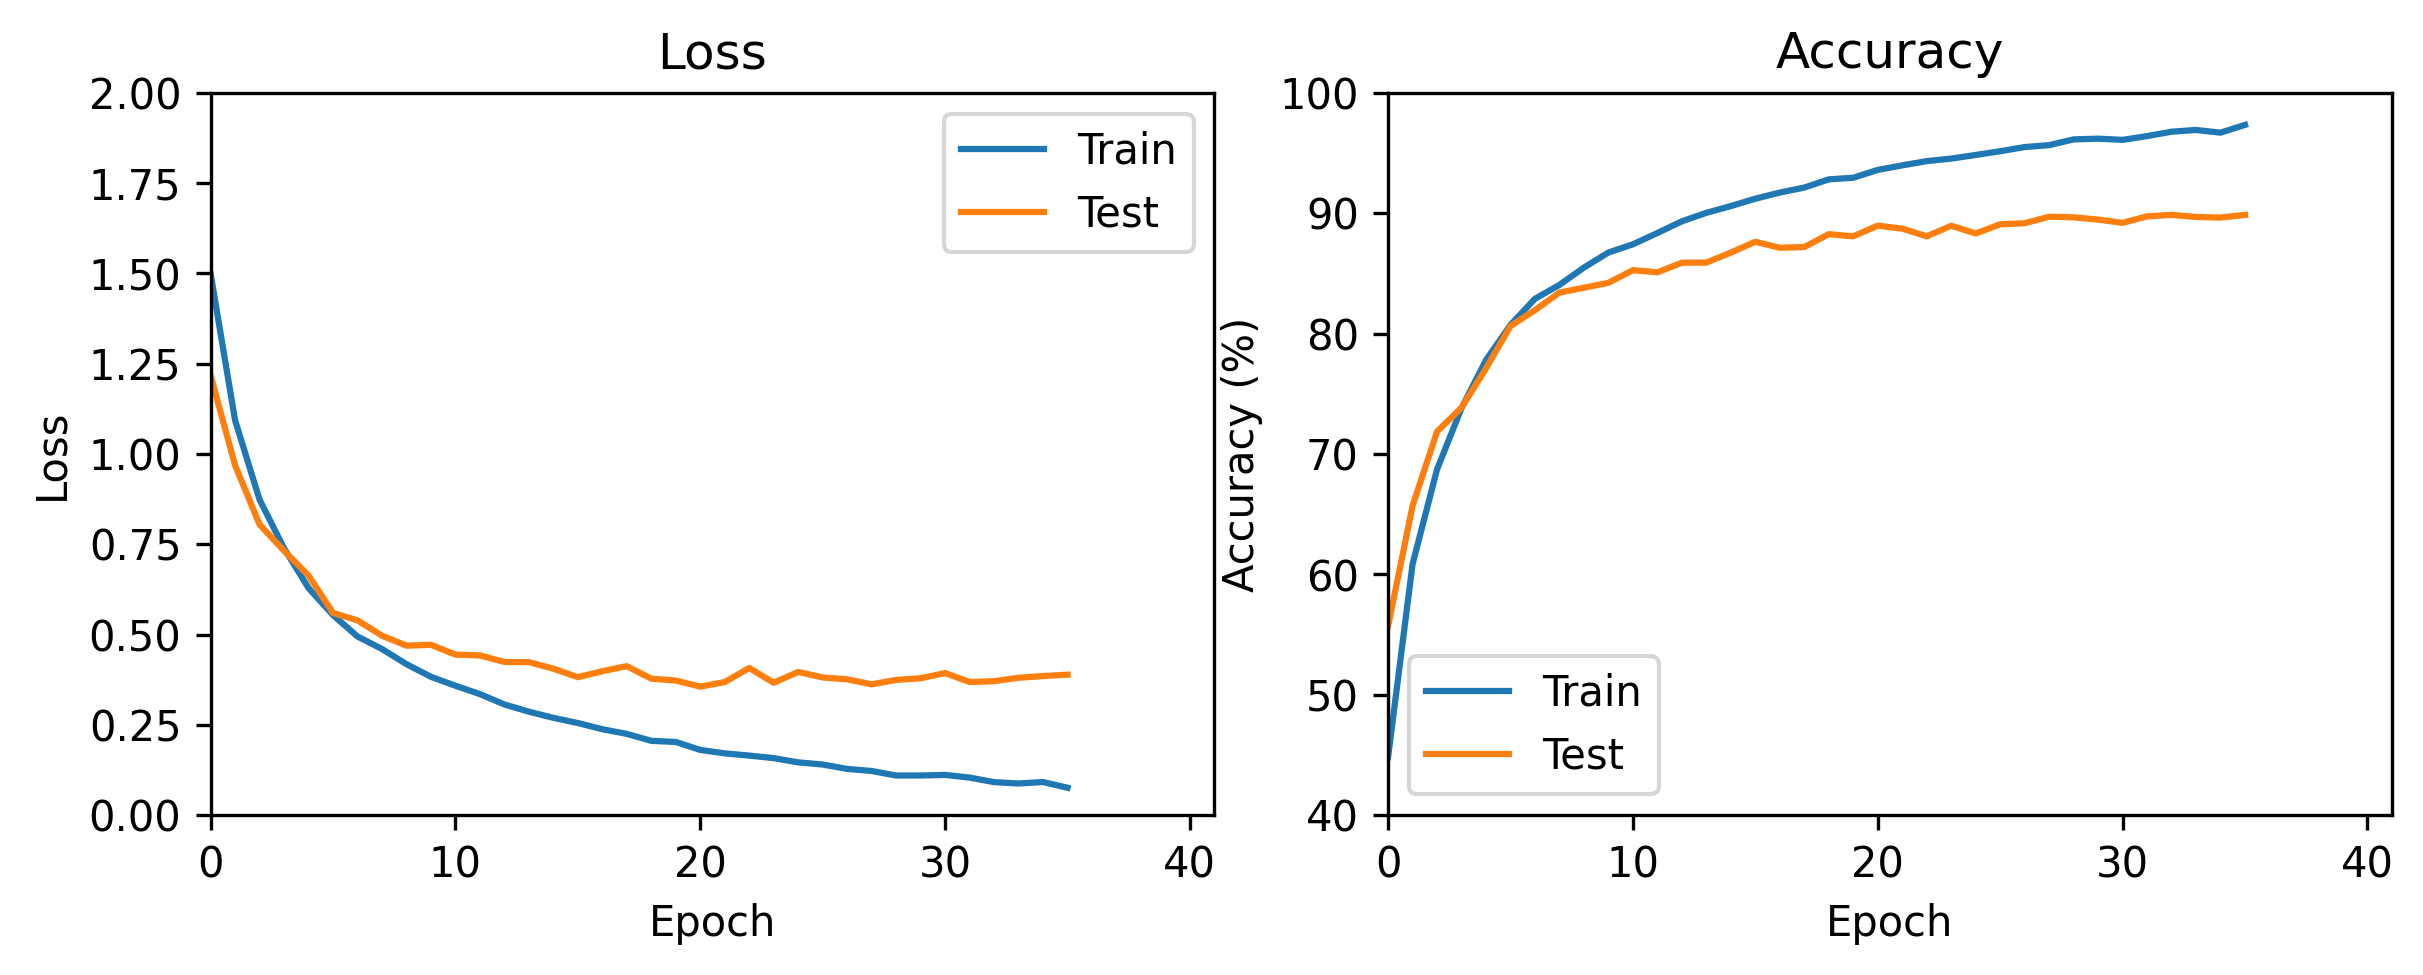

In [8]:
fig, axs = plt.subplots(1, 2,figsize = (8,3),dpi =300)

fig.tight_layout() 
axs[0].plot(train_loss[1:],label = 'Train')
axs[0].plot(test_loss[:-1],label = 'Test')
axs[0].set_title('Loss')
axs[0].set_ylim(0,2)
axs[0].set_xlim(0,41)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(train_acc[1:],label = 'Train')
axs[1].plot(test_acc[:-1],label = 'Test')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_xlim(0,41)
axs[1].set_ylim(40,100)
axs[1].legend()

## Finding "Non-consolidated" images, using the original trainset, without augmentations.

In [ ]:
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_normalized = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = transform_normalize)
trainloader_normalized = torch.utils.data.DataLoader(trainset_normalized, batch_size=1,
                                          shuffle=False, num_workers=2,pin_memory = True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

def imshow(img):
    plt.figure()
    img = img / 5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),aspect = 1)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.show()
 
    
net.eval() 
with torch.no_grad():
    for ind, (data, labels) in enumerate(trainloader_normalized):
        data, labels = data.to(device), labels.to(device)
        outputs = net(data)
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        if (~pred.eq(labels.view_as(pred))).sum().item() > 0:
            for i in np.where(np.squeeze((~pred.eq(labels.view_as(pred))).cpu()))[0]:
               
                imshow(data[i].cpu())
                print(f'ID: {ind} Predicted: {classes[pred[i]]} vs Ground Truth: {classes[labels[i]]}')
                
                 
               

